In [1]:
###### valido para Julia 1.7.2
using LinearAlgebra
using Plots
using Graphs #paquetería para graphos
using Random
using GraphPlot #paqueteria para graficar redes
using SparseArrays
using LaTeXStrings

#using Compose


┌ Info: Precompiling GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1662


In [2]:
#Pkg.add("Compose")

In [3]:
fnt = Plots.font("sans-serif", 15) # Para gráficar loas labels


Plots.Font("sans-serif", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [4]:
F(theta,i,j,k)=exp(im*theta*i*j/k) #son las entradas de la matriz, las exponenciales

function Coin_Fourier(k,theta=2*pi)   #genera la matriz
    
    Cki=zeros(Complex,k,k)

    
    Cki[1,:].=1                # se le agrega 1's a la primera fila
    Cki[:,1].=1                # se le agrega 1's a la primera columna
    for i=1:k-1                #  En este for se va a recorrer cada fila y columna
        for j=1:k-1               ## junto con este otro for
            Cki[j+1,i+1]=F(theta,i,j,k) # se utiliza la función F que se definio arriba
        end
    end
    
    if k==2
        
        ###Este es un parche para un anillo##
        C=zeros(2,2)
        C[1,1]=0
        C[1,2]=1
        C[2,1]=1
        C[2,2]=0
        ######################################
       return (1/sqrt(k))*(Cki*C)  # se le multiplica por el 1/sqrt(grado) al que corresponde 
    else
       return (1/sqrt(k))*(Cki) 
    end
end


## Neceisto algo que si le doy un nodo me diga que base se le asigna###
function Base_del_Nodo(Nodo,A)
    k=sum(A[Nodo,:]) # Sumamos cada entrada eso nos dará el grado del nodo
    Id=Matrix(1I, k, k) # generamos la matriz identidad que corresponde al grado
    return Id #La retorna
              ## Esto genera la base segun sea el grado de cada nodo
end

Base_del_Nodo (generic function with 1 method)

In [5]:
function U_evolution(n,A,ψ)

    ### Para ver que vectores hay tenemos que recorrer cada uno... PARA UNA MATRIZ ψ DADA
    for t=1:n
        for i=1:size(A)[1]   #PAra un nodo i me va a dar el vector que le corresponde Ö

            if rowvals(ψ[i,:])==[]       # si no hay ningún peso entonces continua
               continue 
            else
               #println(ψ[i,:]) 
            end

            Nodos_de_i=rowvals(A[i,:])   # vecinos del nodo i
            Basis=Base_del_Nodo(i,A)     # base del nodo i


            v=zeros(length(Nodos_de_i)) # el vector del nodo i
            for (index,value) in enumerate(Nodos_de_i)   # hacemos dos indices uno que enlista los elemntos y otro los nodos conectados al nodos i
            v+=Basis[:,index]*ψ[i,value]
            end


            #Al vector le aplicamos el operador moenda
            k=sum(A[i,:])  # calculamos
            v=Coin_Fourier(k)*v  ## El vector despues de la moenda de Fourier 


            ## Hay que reemplazar los pesos (SEGUIMOS EN EL NODO 1)
            for (index,value) in enumerate(Nodos_de_i)   # hacemos dos indices uno que enlista los elemntos y otro los nodos conectados al nodos 1
                ψ[i,value]=v[index]
            end
        end
        ### operador S### es solo el trasnpuesto de la matriz ψ
        ψ=sparse(transpose(ψ))
    end
    return ψ
end

U_evolution (generic function with 1 method)

In [6]:
function ψ_inital_local()
    ψ=sparse(zeros(Complex,size(A))) ## Creo la matriz de coeficientes psi
    ## Creamos un estado 
    vec=[1/sqrt(2) * 1, 1/sqrt(2) * 1*im  ]
    for (i,val_i) in enumerate(rowvals(A[Nd_central,:]))
        ψ[Nd_central,val_i]=vec[i] 
    end
    return ψ
end

function ψ_inital_grado_2()
    
    Nodo_inicial=0
    for i=1:NODOS
        if sum(A[i,:])==2
            Nodo_inicial=i
            break
        end
    end
    
    ψ=sparse(zeros(Complex,size(A))) ## Creo la matriz de coeficientes psi
    ## Creamos un estado 
    vec=[1/sqrt(2) * 1, 1/sqrt(2) * 1*im  ]
    for (i,val_i) in enumerate(rowvals(A[Nodo_inicial,:]))
        ψ[Nodo_inicial,val_i]=vec[i] 
    end
    return ψ
end

ψ_inital_grado_2 (generic function with 1 method)

# Entropia
Solo sirve para quiralidad uniforme es decir en este caso 2

In [7]:
function Density_M_Q(Q,A,ψ)
    Dst=zeros(ComplexF64,Q,Q) # Q es el grado más alto
    for m=1:NODOS # Construimos la matriz de densidad
        for (jk,val_jk) in enumerate(rowvals(A[m,:]))
            for (jkp,val_jkp) in enumerate(rowvals(A[m,:]))
                #println(val_jk," ",val_jkp)
                Dst[jk,jkp]+=ψ[m,val_jk]*conj(ψ[m,val_jkp])  
            end
        end
    end
    return Dst
end

Density_M_Q (generic function with 1 method)

# PROGRAMA

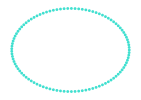

In [8]:
#Red de prueba
NODOS=101

g = SimpleGraph(NODOS)  #defeinimos nodos de 1 al 3

for i=1:NODOS-1
   add_edge!(g,i,i+1)  
end
add_edge!(g,NODOS,1)

#add_edge!(g,90,7)

gplot(g, #nodelabel=1:NODOS,
    layout=circular_layout)   #graficamos la red
#g=watts_strogatz(NODOS,2,0.0)
#gplot(g, nodelabel=1:NODOS,layout=circular_layout)
#savefig("./Red_anillo_atajo.png")

In [9]:
A=adjacency_matrix(g);
Nd_central=Int64((NODOS-1)/2 +1)



ψ=ψ_inital_local();

#ψ=ψ_inital_grado_2();

Nd_central=0
if NODOS%2==0
    Nd_central=Int64((NODOS)/2 +1)
else
    Nd_central=Int64((NODOS-1)/2 +1)
end

Nx=-Nd_central+1:1:(NODOS-Nd_central)
Nx[end]

50

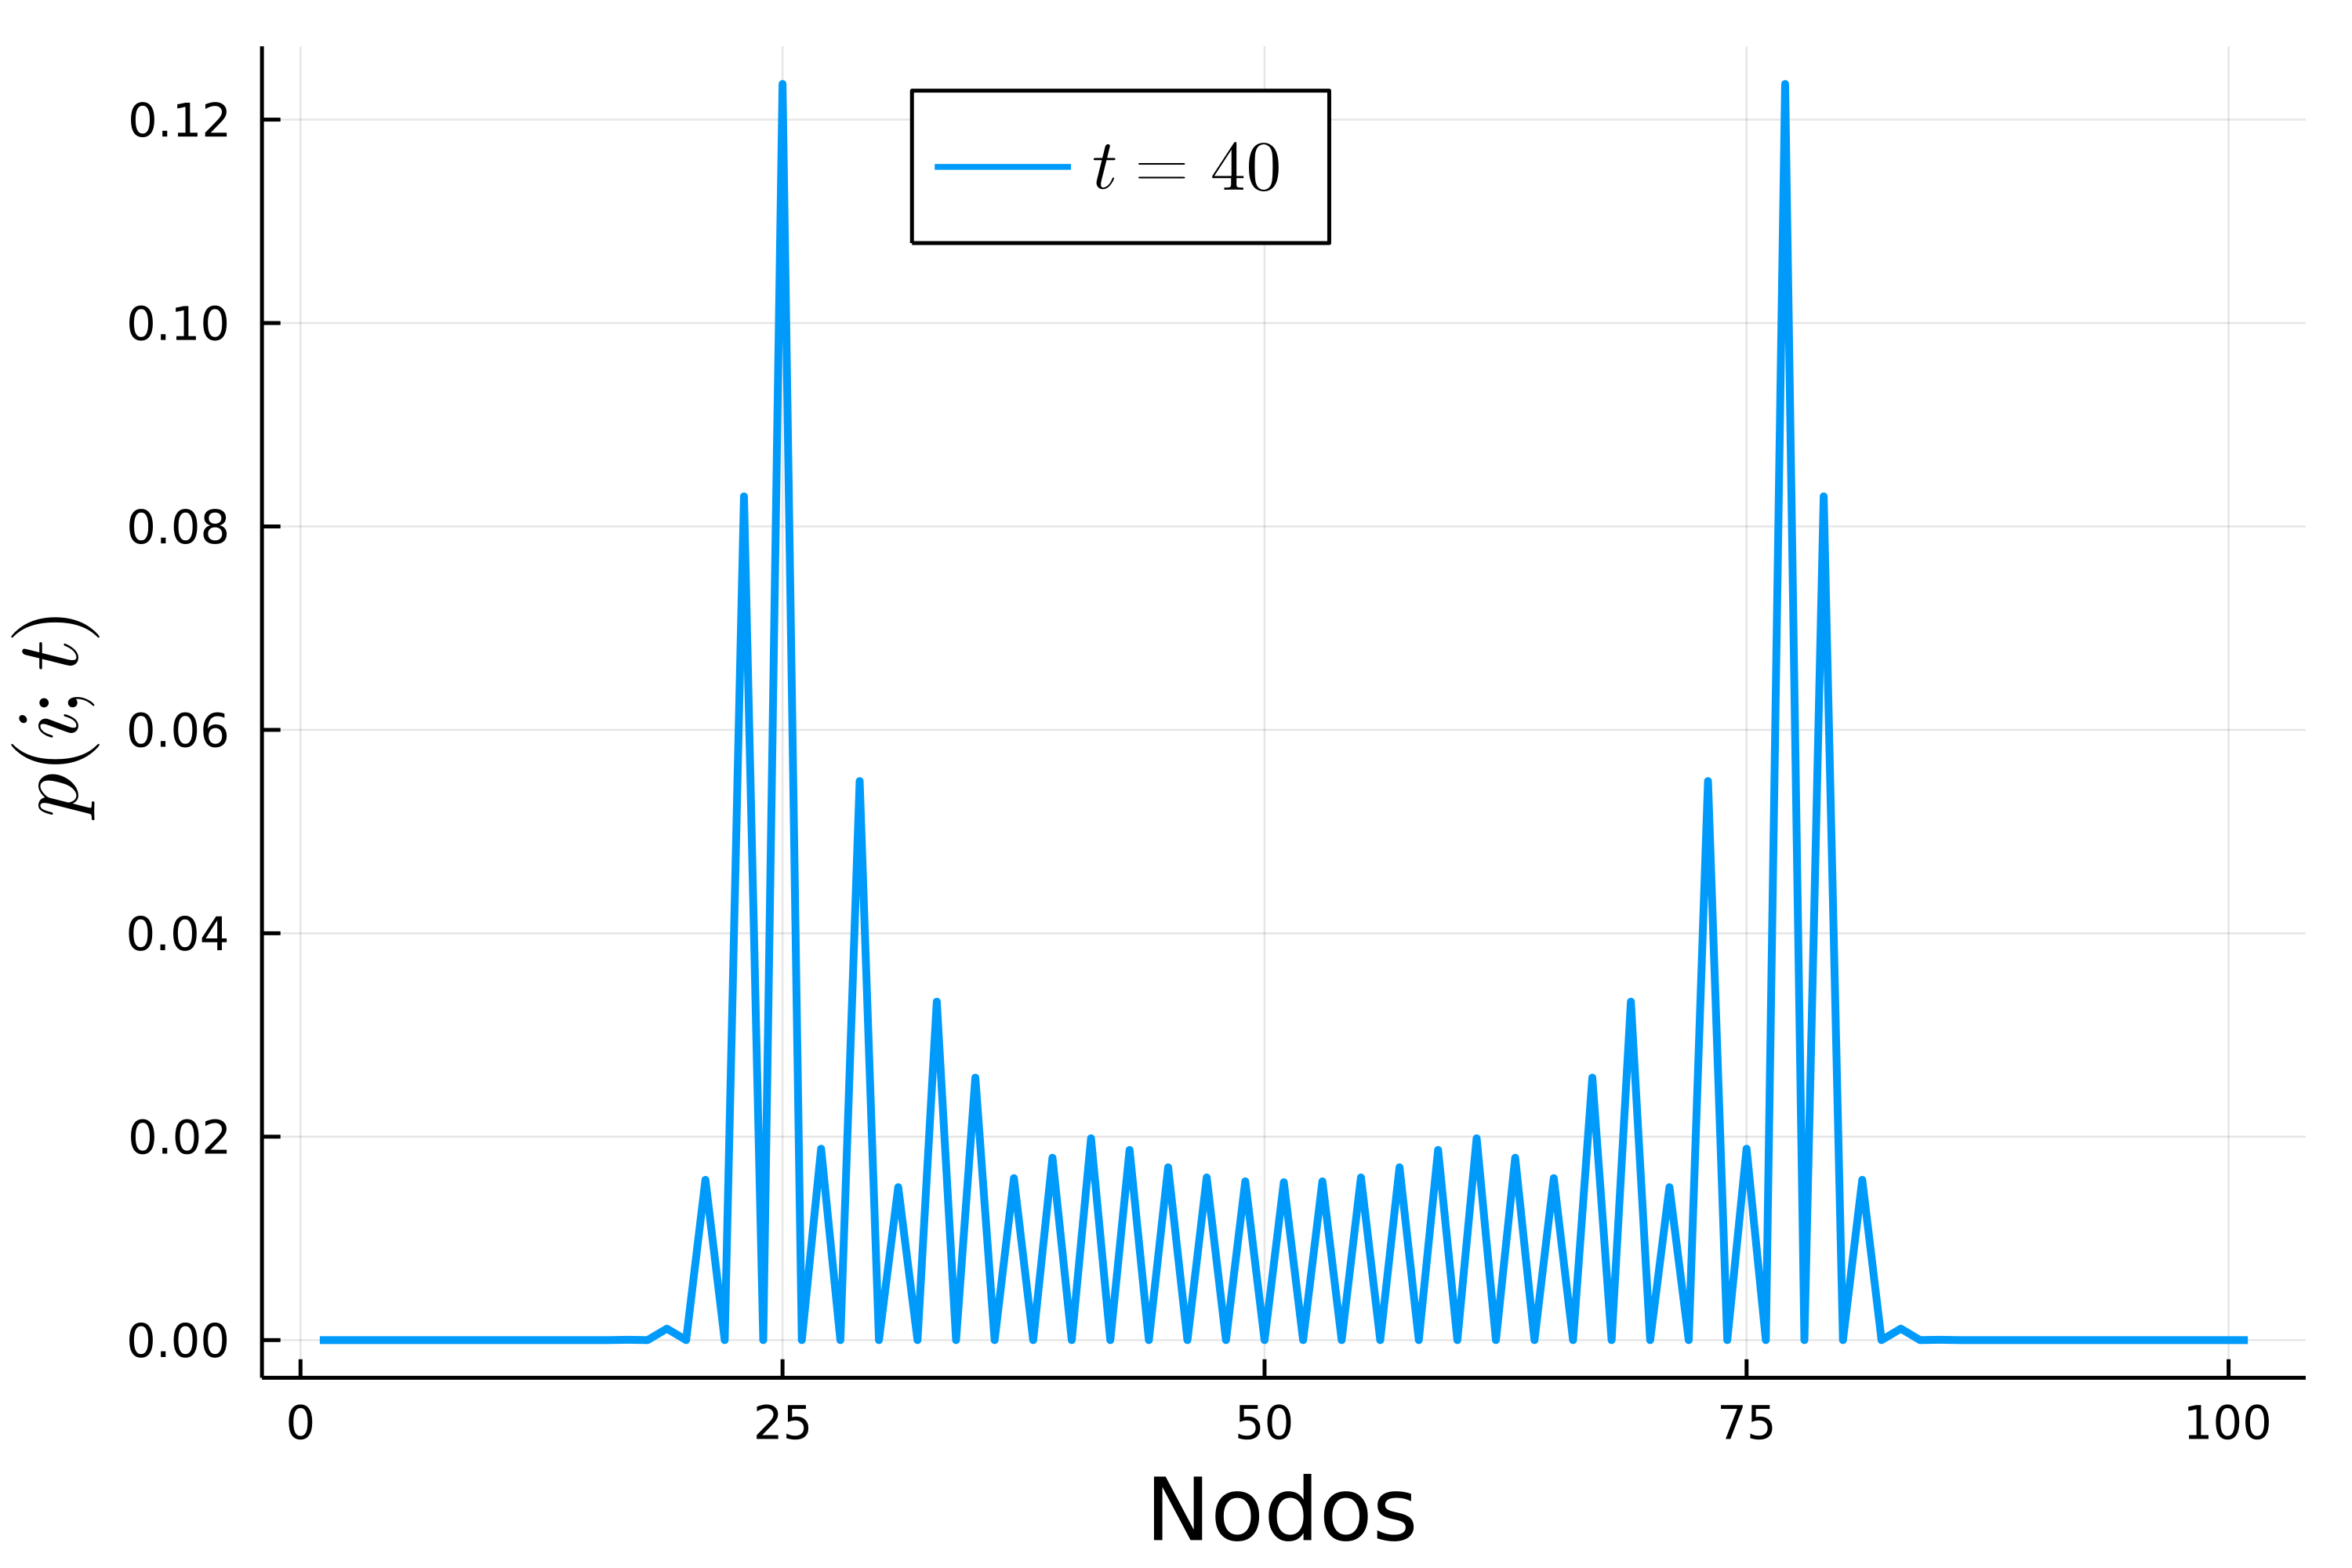

In [23]:
Pasos=40
B=U_evolution(Pasos,A,ψ)
BB=abs2.(Matrix(B));

pesos=zeros(size(A)[1])
for i=1:length(pesos)
    pesos[i]=sum(BB[i,:])
end

Space=1:1:NODOS

SpaceP=zeros(0)
ProbaP=zeros(0)
for i=1:length(Space)
    if pesos[i]!=0.0
        append!(ProbaP, pesos[i])
        append!(SpaceP, Nx[i])
    end
end

#bar(pesos,guidefont=fnt,ylabel=L"p(i;t)",xlabel="Nodos",label="t=$Pasos")
# plot(SpaceP,ProbaP,guidefont=fnt,lw=2,label=L"t="*latexstring("$Pasos"),#title=L"\gamma=\phi=\pi/2,\sigma=5"
#      ylabel=L"p(i;t"*L")",xlabel="Nodos",fmt = :png, dpi=500,legendfontsize=12,legend=:top)

plot(pesos,guidefont=fnt,lw=2,label=L"t="*latexstring("$Pasos"),#title="Caminata Cuántica en Tiempo Discreto",
       ylabel=L"p(i;t"*L")",xlabel="Nodos",fmt = :png, dpi=500,legendfontsize=12,legend=:top)



In [24]:
savefig("./QWDT_NO_Title.png")

┌ Info: Saved animation to 
│   fn = /home/sebas/Escritorio/Cosas de Git/quantum-walks-julia/Anillo/9_local_walker_Strogatz_0p0_Presentacion.gif
└ @ Plots /home/sebas/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/sebas/Escritorio/Cosas de Git/quantum-walks-julia/Anillo/9_local_walker_Strogatz_0p0_Presentacion.gif")
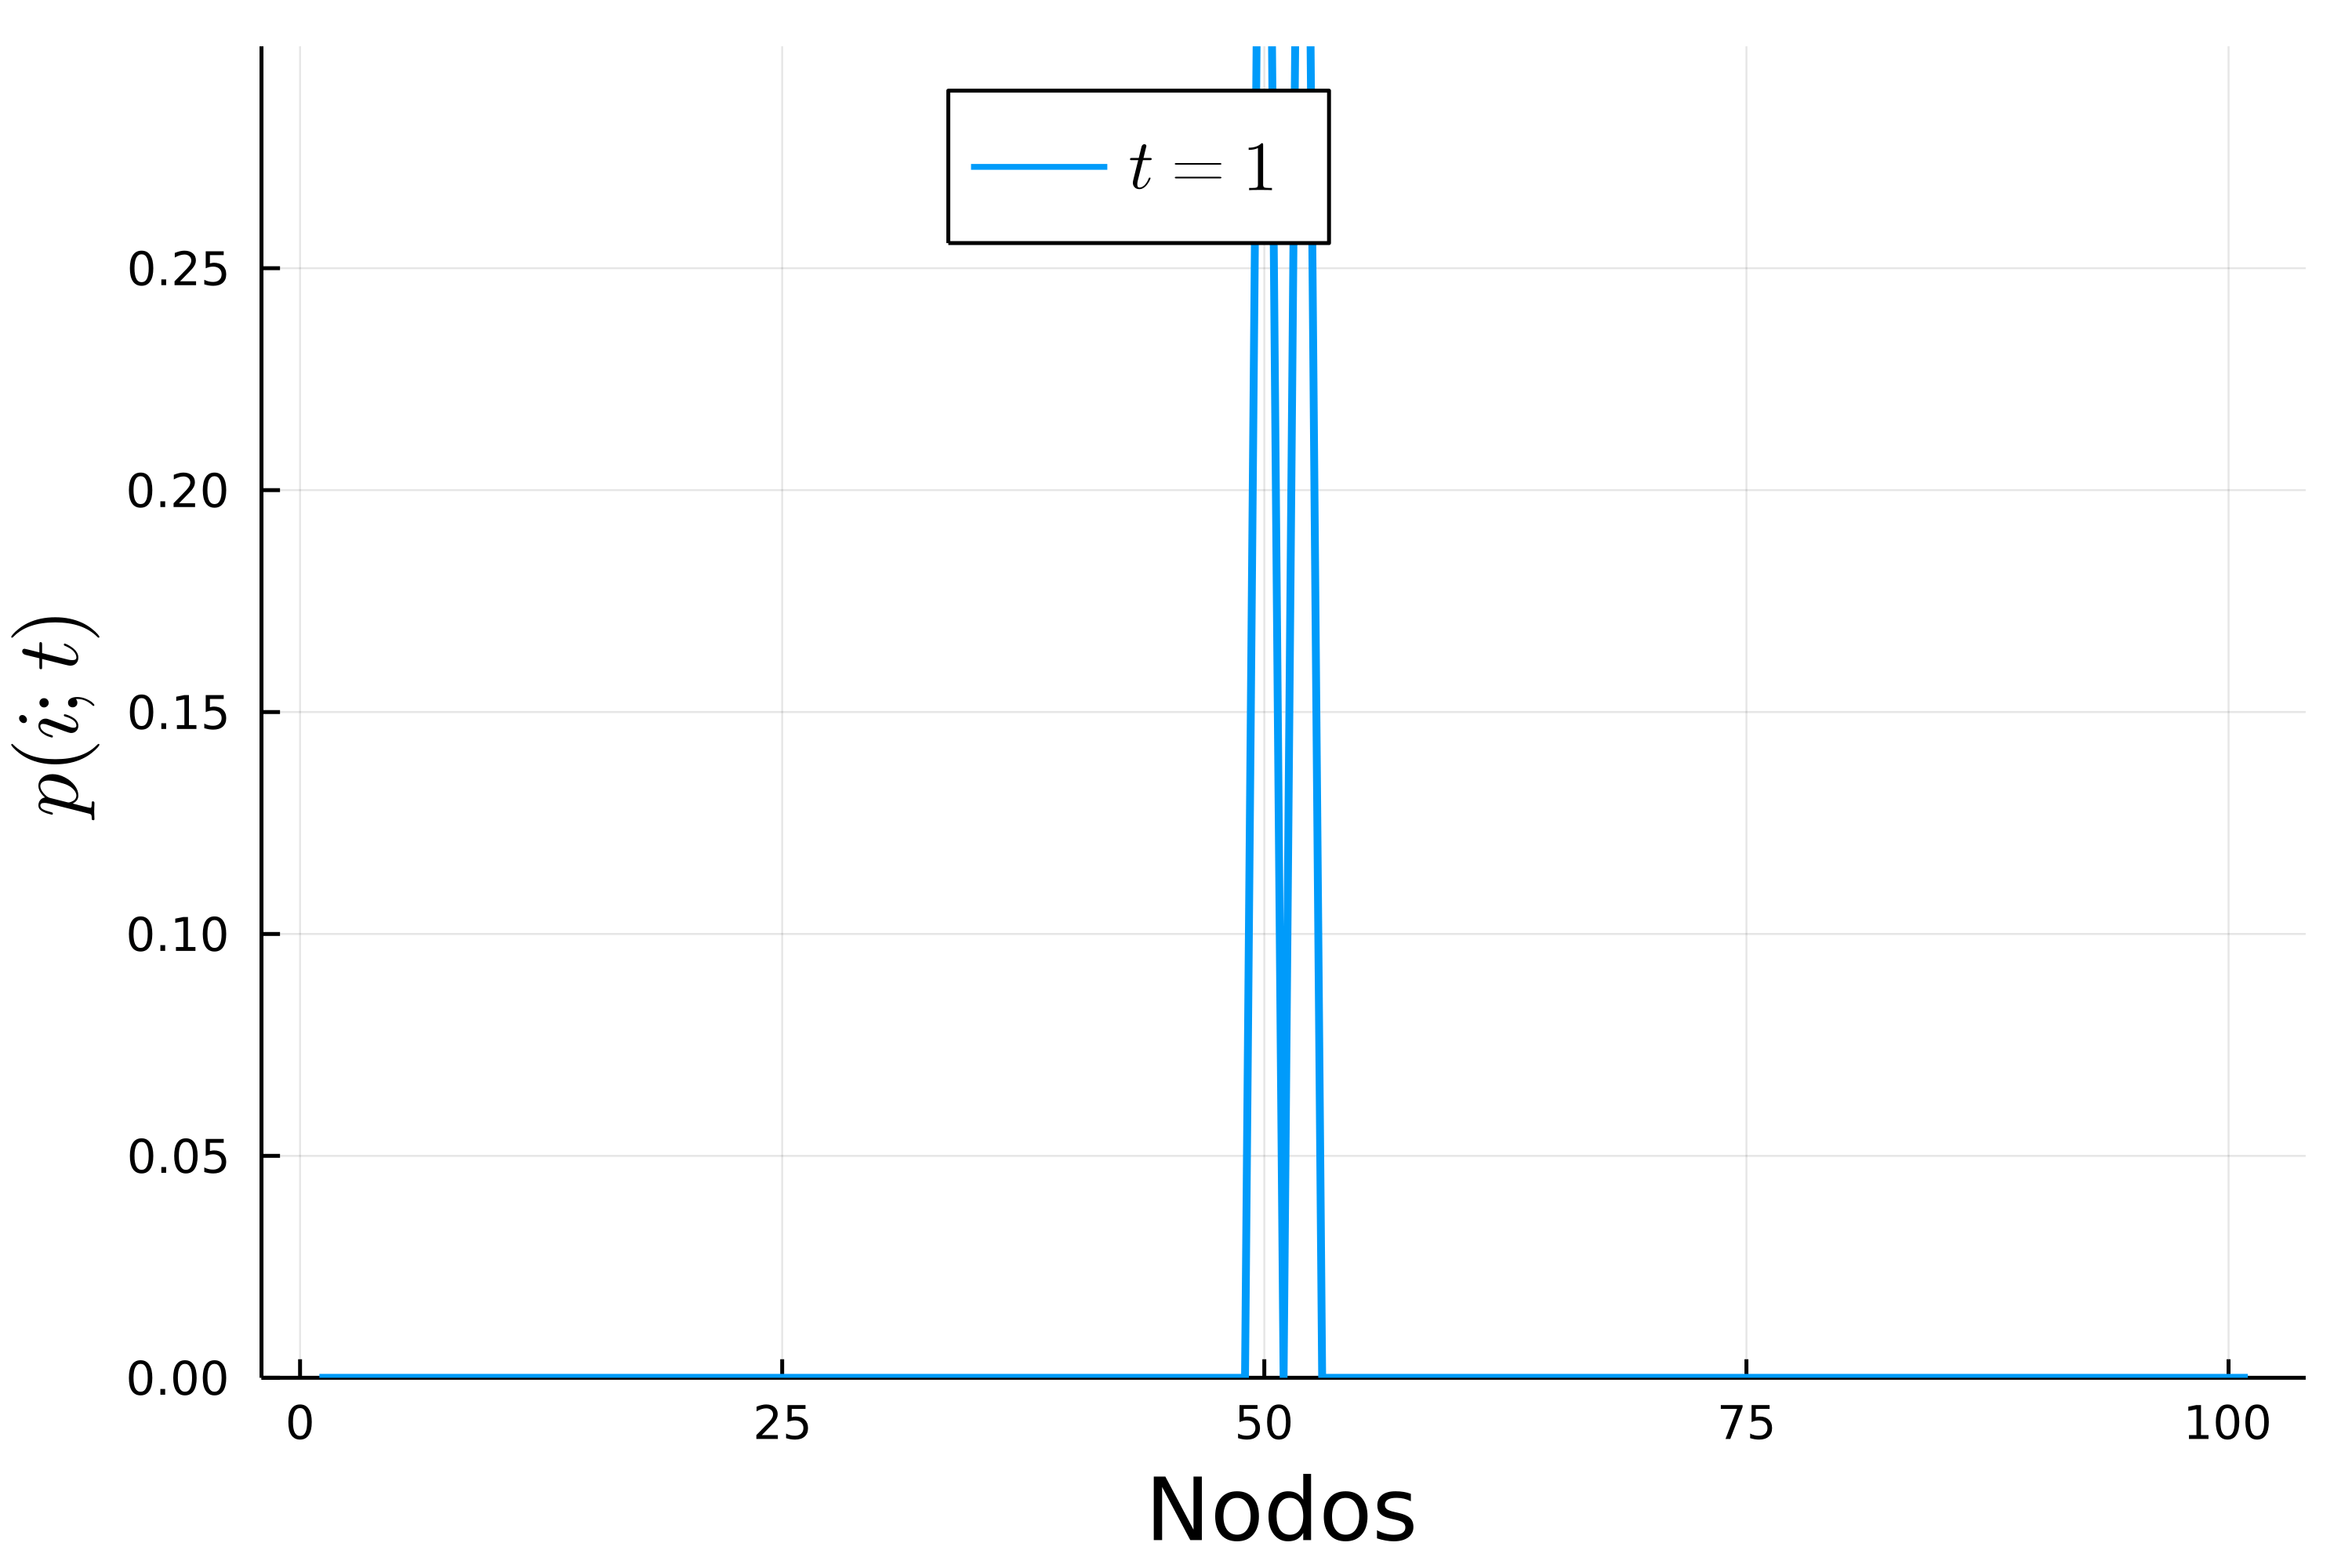

In [27]:

anim= @animate for l=1:1:50
    #ψ=ψ_inital_grado_2();
    ψ=ψ_inital_local();
    B=U_evolution(l,A,ψ)
    BB=abs2.(Matrix(B))
    pesos=zeros(size(A)[1])
    for i=1:length(pesos)
        pesos[i]=sum(BB[i,:])
    end
    SpaceP=zeros(0)
    ProbaP=zeros(0)
    for i=1:length(Space)
        if pesos[i]!=0.0
            append!(ProbaP, pesos[i])
            append!(SpaceP, Nx[i])
        end
    end

    #bar(pesos,guidefont=fnt,ylabel=L"p(i;t)",xlabel="Nodos",label="t=$l",ylim=(0,0.5))
#     plot(SpaceP,ProbaP,guidefont=fnt,lw=2,label=L"t="*latexstring("$l"),#title=L"\gamma=\phi=\pi/2,\sigma=5"
#      ylabel=L"p(i;t"*L")",xlabel="Nodos",fmt = :png, dpi=250,legendfontsize=12,ylim=(0,0.2),xlim=(Nx[1],Nx[end]))
    plot(pesos,guidefont=fnt,lw=2,label=L"t="*latexstring("$l"),#title="Caminata Cuántica en Tiempo Discreto",
       ylabel=L"p(i;t"*L")",xlabel="Nodos",fmt = :png, dpi=500,legendfontsize=12,legend=:top,ylim=(0,0.3))
end

gif(anim,"./9_local_walker_Strogatz_0p0_Presentacion.gif", fps=10)



In [63]:
# g=watts_strogatz(NODOS,2,0.6)
# A=adjacency_matrix(g);

###ENTROPIA

n=300#Pasos
Sn=zeros(n)


### Buscamos el grado más alto
grado_m=0
for i=1:NODOS
    if sum(A[i,:])>grado_m
        grado_m=sum(A[i,:])
    end
end
Q=grado_m
#####

for i=1:n
    ψ=ψ_inital_local();
    Dst=Density_M_Q(Q,A,U_evolution(i,A,ψ))
    lamb=eigvals(Dst)
    for j=1:Q
        if lamb[j]<=0
            continue
        else
            Sn[i]-=lamb[j]*log(lamb[j])
        end
    end
end
#scatter!(Sn,label=false,markersize=2, fmt = :png, dpi=500)

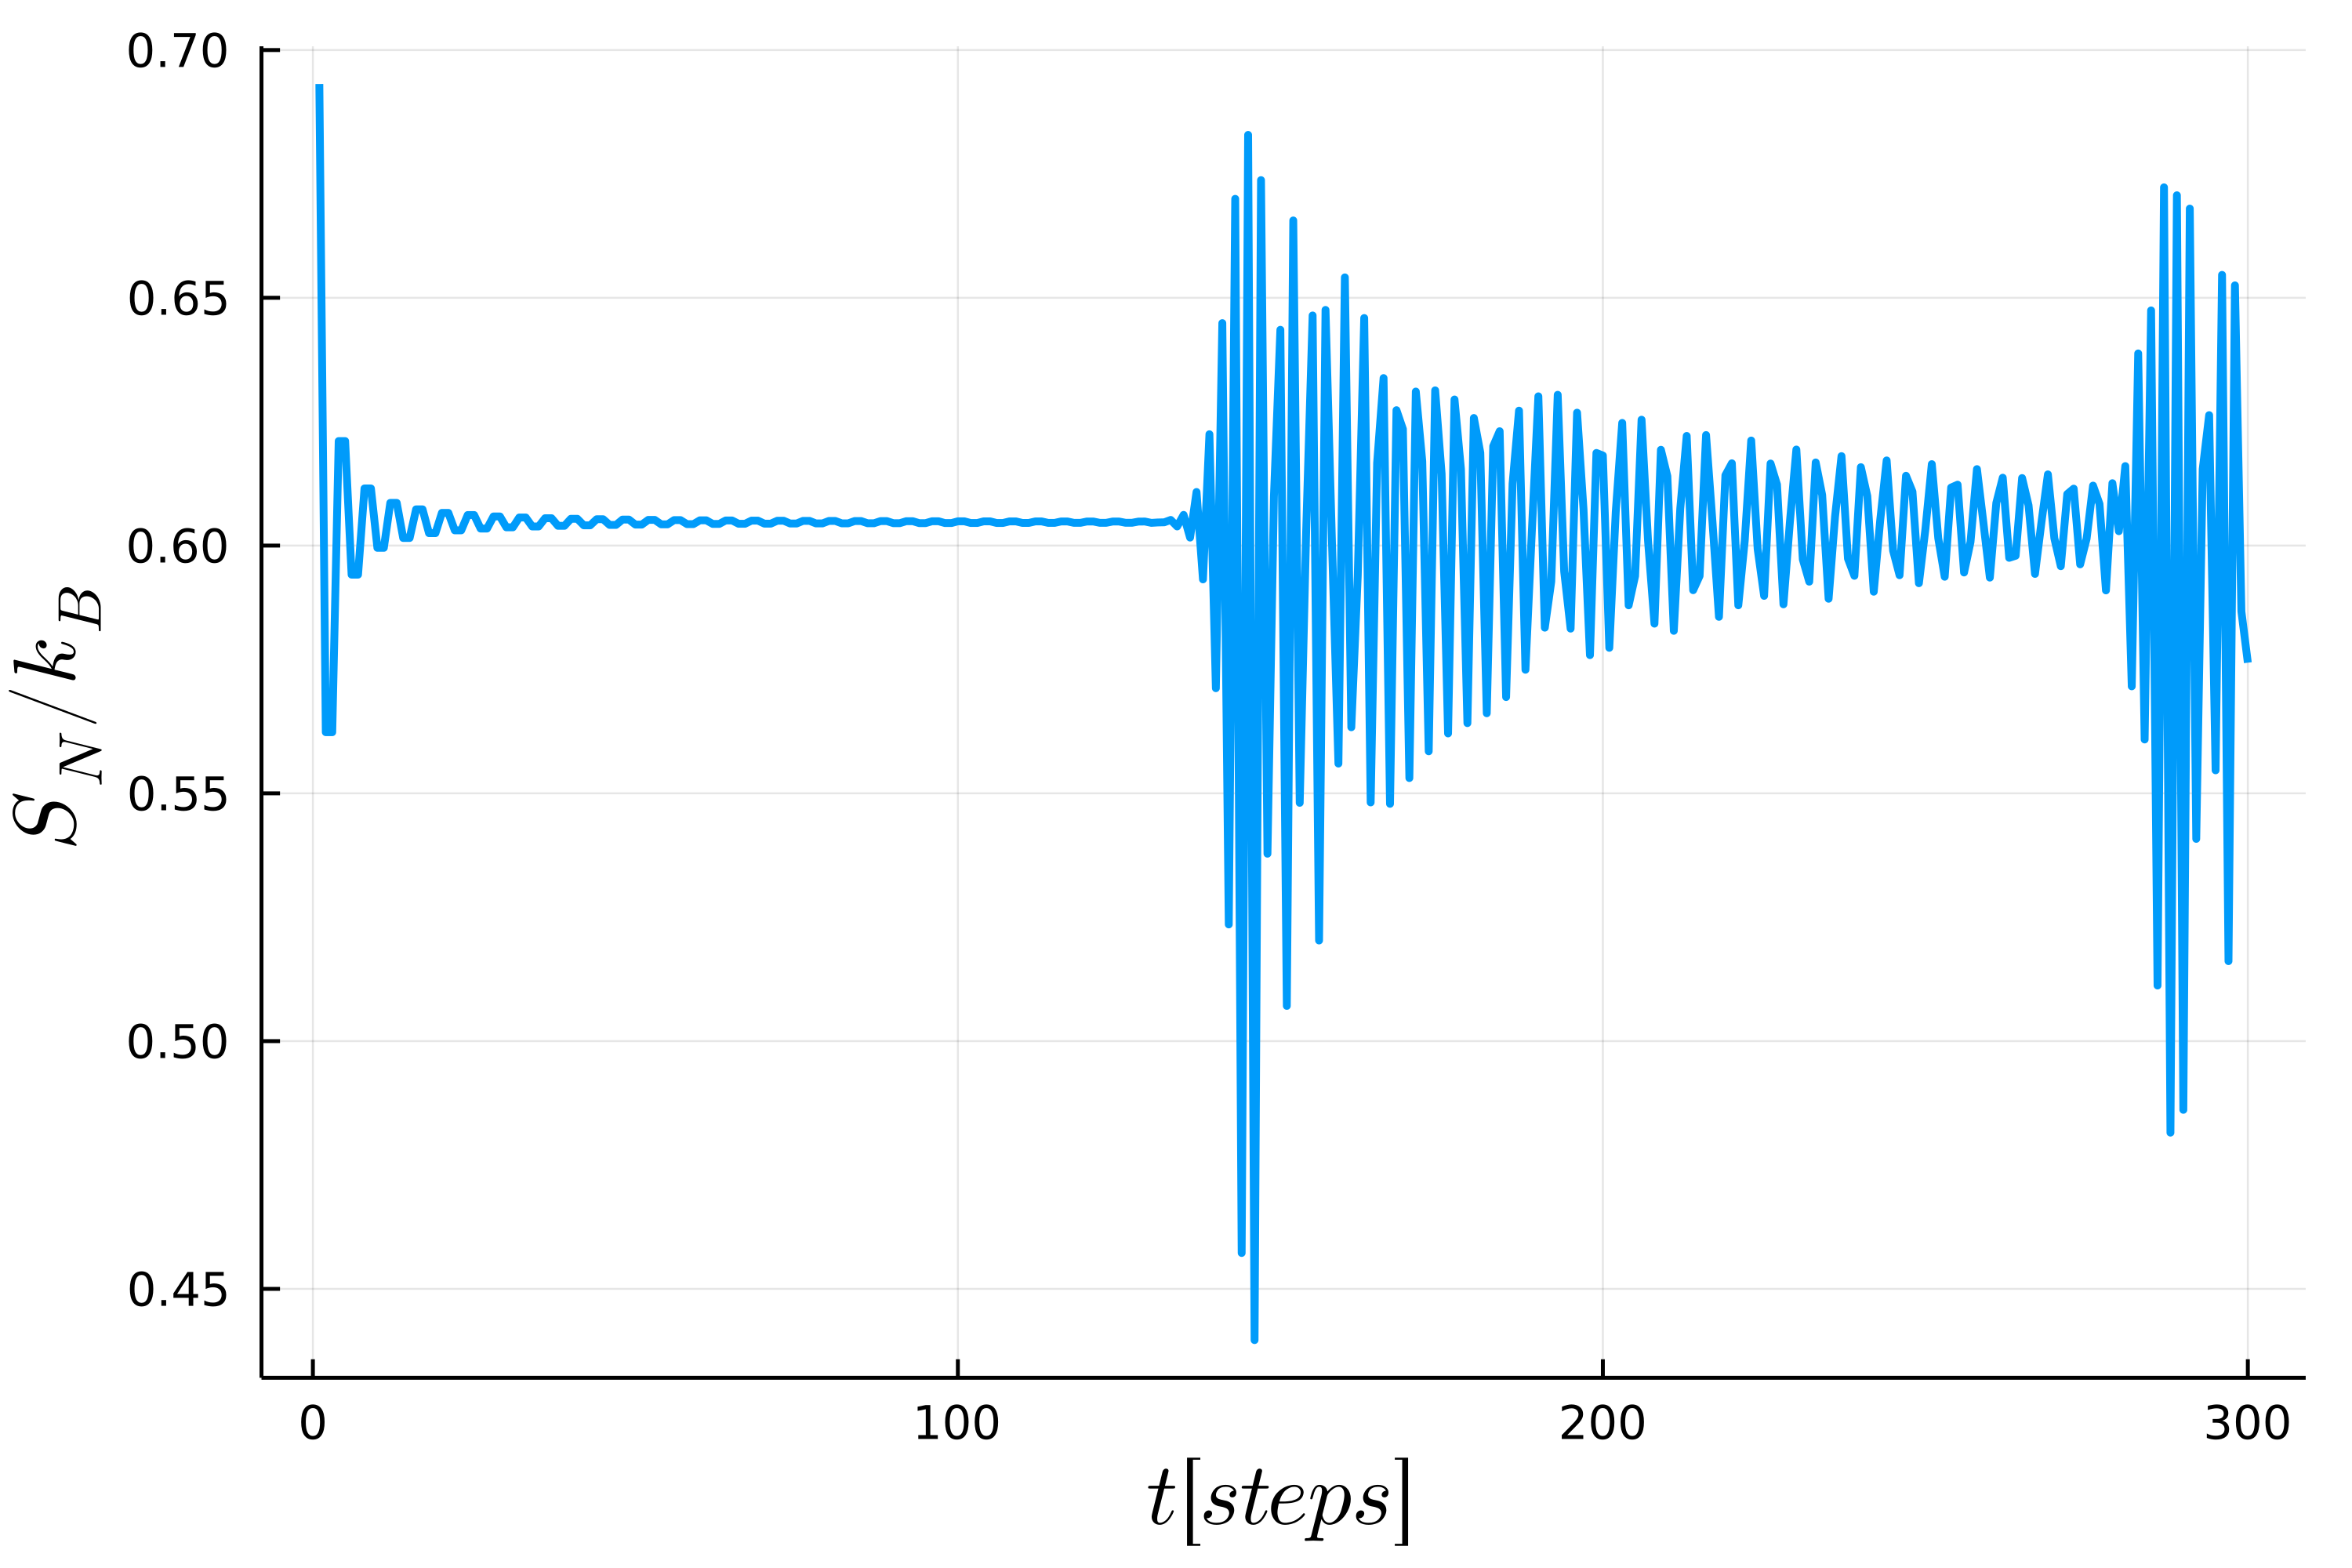

In [64]:
plot(Sn,ylabel=L"S_N/k_B",xlabel=L"t[steps]",label=false,
    guidefont=fnt,legend=:bottomright,
    legendfontsize=12.0,lw = 2,fmt = :png, dpi=500
    #xlims=(400,900),ylims=(0.5,0.65)
    )
#scatter!(Sn,label=false,markersize=2)

In [237]:
savefig("./9_Local_walker_Strogatz_0p0.png")